# Exploratory data analysis notebook

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
data = pd.read_csv("../data/interim/ner_dataset.csv", encoding="latin1").fillna(method="ffill")

In [3]:
display(data.head()); display(data.tail())

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [4]:
data.shape

(1048575, 4)

We've got 1048575 words in the dataset, however only 35178 unique ones. Each word has its PoS tag and NER tag.

In [5]:
data.describe()

,Sentence #,Word,POS,Tag
count,1048575,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 22480,the,NN,O
freq,104,52573,145807,887908


Those 1048575 words create 47959 sentences.

---

## TAGS

In [6]:
pd.DataFrame({'Percentage': data.groupby(('Tag')).size() / len(data)}).sort_values(by='Percentage', ascending=False).head()

,Percentage
Tag,
O,0.846776
B-geo,0.035900
B-tim,0.019391
B-org,0.019210
I-per,0.016452


As we could expect the most frequent tag is the 'O' that basically says that the word is not an entity or it is other (not categorized) entity. Two following tags are location names (geo), time (tim), organisation (org), person (per). 

We can clearly see the class imbalance on the graph below.

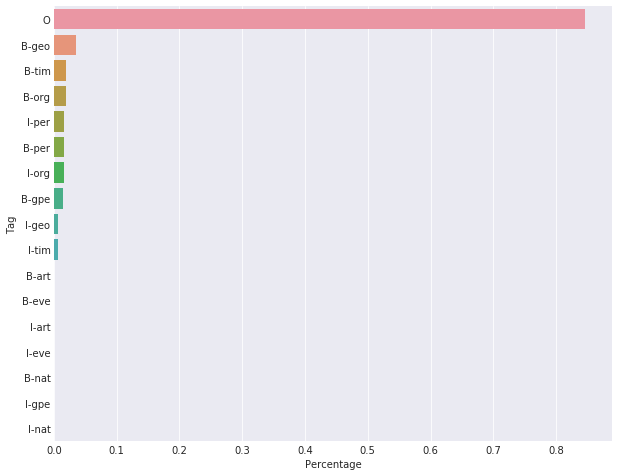

In [7]:
df_perc = pd.DataFrame({'Percentage': data.groupby(('Tag')).size() / len(data)}).sort_values(by='Percentage', ascending = False).reset_index()
plt.figure(figsize=(10,8))
sns.barplot(df_perc.Percentage, df_perc.Tag)

Let's see how it looks without 'O' tag

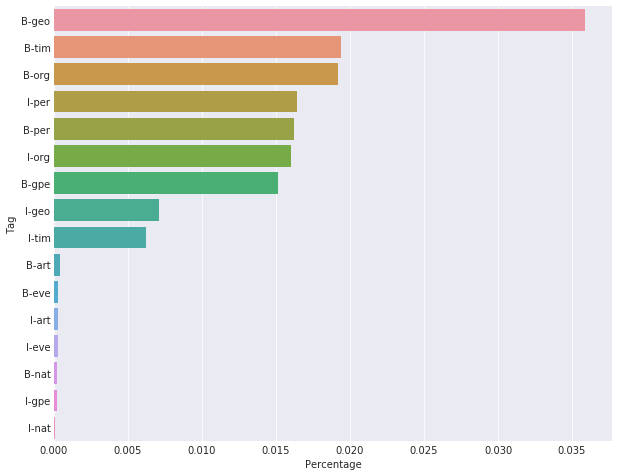

In [8]:
plt.figure(figsize=(10,8))
sns.barplot(df_perc[df_perc.Tag != 'O'].Percentage, df_perc[df_perc.Tag != 'O'].Tag)

I could e.g. try undersampling sentences with only 'O' tag, however that might affect negatively bidirectional capabilities of the models.

> Using appropriate metric (F1 Score) should overcome this problem.

--- 

## SENTENCES

What length of sequence would be optimal?

In [9]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
# Get full document data struce
getter = SentenceGetter(data)

# Get sentence data
sentences = [[s[0] for s in sent] for sent in getter.sentences]

In [10]:
sentence_length = []
for i in sentences:
    sentence_length.append(len(i))

In [11]:
max(sentence_length)

104

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


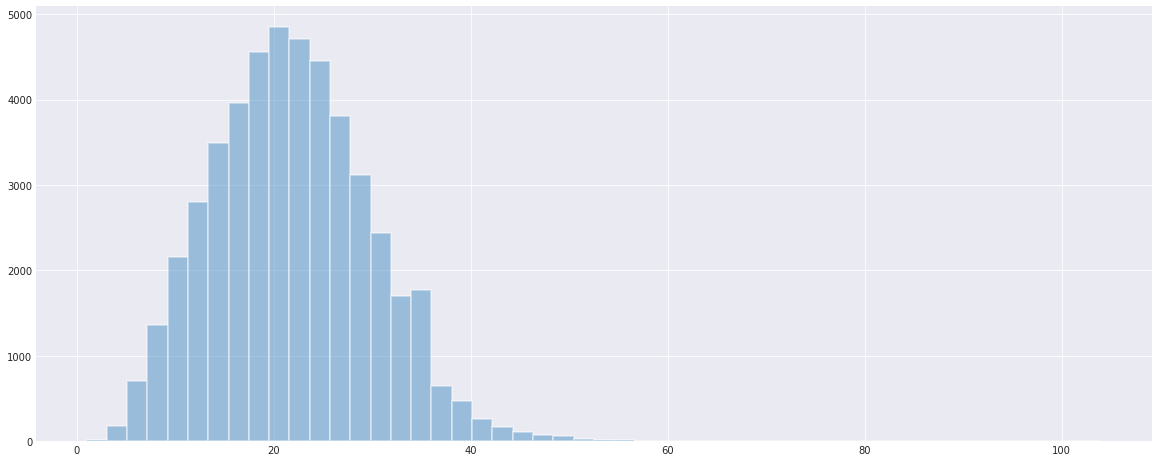

In [12]:
plt.figure(figsize=(20,8))
sns.distplot(pd.DataFrame(sentence_length), kde=False, hist_kws=dict(edgecolor="white", linewidth=2))

It seems that the most reasonable sequence length would be around 40 or 45 - we would cover most cases and wont sacrifice training and inference time (by going for the maximium sequence length).

In [13]:
print(f'We are going to cut {round(sum(i > 45 for i in sentence_length)/len(sentence_length), 4)}% of sentences to a length of 45')

We are going to cut 0.0059% of sentences to a length of 45
